# Model

In [89]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Lambda, RepeatVector, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from tensorflow.keras.callbacks import EarlyStopping

# Function to load and process flight data
def load_and_process_flight_data(file_paths):
    flights = []
    for file_path in file_paths:
        df = pd.read_csv(file_path, delimiter='\t')
        if 'Time(milli)' in df.columns:
            df = df.drop(columns=['Time(milli)'])
        flights.append(df.values)
    return flights

# Directory containing the adjusted flight data files
adjusted_data_directory = './data/adjusted_flights/'
adjusted_file_pattern = os.path.join(adjusted_data_directory, 'SimuladorDeVoo_*.txt')
adjusted_files = glob.glob(adjusted_file_pattern)

# Load and process the adjusted flight data
flight_data = load_and_process_flight_data(adjusted_files)

# Normalize the data
all_data = np.concatenate(flight_data, axis=0)
data_mean = np.mean(all_data, axis=0)
data_std = np.std(all_data, axis=0)
data_std[data_std == 0] = 1e-8  # Add a small value where std is 0 to avoid division by zero

flight_data = [(df - data_mean) / data_std for df in flight_data]

# Find the maximum length of flights
max_length = max(len(df) for df in flight_data)

# Pad all flights to have the same length
padded_flights = np.array([np.pad(df, ((0, max_length - len(df)), (0, 0)), mode='constant') for df in flight_data])

# Define the VAE architecture
timesteps = max_length
input_dim = padded_flights.shape[2]
latent_dim = 50  # Increased latent dimension

# Encoder part of the VAE
inputs = Input(shape=(timesteps, input_dim))
h = Bidirectional(LSTM(256, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01)))(inputs)
h = Dense(128, activation='relu')(h)
h = Dropout(0.4)(h)  # Added dropout for regularization

# Latent space representation
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Sampling function to generate latent vectors
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder part of the VAE
decoder_h = Dense(128, activation='relu')
h_decoded = decoder_h(RepeatVector(timesteps)(z))
h_decoded = Dropout(0.4)(h_decoded)  # Apply dropout to the output of the Dense layer
decoder_mean = LSTM(256, return_sequences=True)
decoder_output = TimeDistributed(Dense(input_dim, activation='linear'))

x_decoded_mean = decoder_mean(h_decoded)
x_decoded_mean = decoder_output(x_decoded_mean)

# Define the VAE model
vae = Model(inputs, x_decoded_mean)

# Define the VAE loss
reconstruction_loss = mse(inputs, x_decoded_mean)
reconstruction_loss = K.sum(reconstruction_loss, axis=[1])  # Sum over the timesteps
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
kl_weight = 0.001  # Weighted KL divergence
vae_loss = K.mean(reconstruction_loss + kl_weight * kl_loss)

vae.add_loss(vae_loss)

# Learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
vae.compile(optimizer=optimizer)
vae.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the VAE with early stopping
vae.fit(padded_flights, epochs=1_000_000, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Extract the decoder model
decoder_input = Input(shape=(latent_dim,))
_h_decoded = RepeatVector(timesteps)(decoder_input)
_h_decoded = decoder_h(_h_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
_x_decoded_mean = decoder_output(_x_decoded_mean)

decoder = Model(decoder_input, _x_decoded_mean)

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 39, 21)]             0         []                            
                                                                                                  
 bidirectional_14 (Bidirect  (None, 512)                  569344    ['input_29[0][0]']            
 ional)                                                                                           
                                                                                                  
 dense_70 (Dense)            (None, 128)                  65664     ['bidirectional_14[0][0]']    
                                                                                                  
 dropout_23 (Dropout)        (None, 128)                  0         ['dense_70[0][0]']     

In [90]:
# Generate new synthetic flight data using the decoder
def generate_synthetic_flights(decoder, num_samples, latent_dim):
    z_samples = np.random.normal(size=(num_samples, latent_dim))
    generated_sequences = decoder.predict(z_samples)
    return (generated_sequences * data_std) + data_mean

num_synthetic_flights_list = [7, 15, 30, 45, 60, 150]

for num_synthetic_flights in num_synthetic_flights_list:
    synthetic_flights = generate_synthetic_flights(decoder, num_synthetic_flights, latent_dim)

    # Save the generated sequences
    def save_generated_sequences(sequences, save_dir):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        for i, sample in enumerate(sequences):
            sample_df = pd.DataFrame(sample, columns=[
                'LAT(deg)', 'LON(deg)', 'ALT(m)', 'Phi(deg)', 'Theta(deg)', 'Psi(deg)',
                'Vx(m/s)', 'Vy(m/s)', 'Vz(m/s)', 'P(deg/s)', 'Q(deg/s)', 'R(deg/s)',
                'Nx(m/s2)', 'Ny(m/s2)', 'Nz(m/s2)', 'Radial(deg)', 'Distance(m)', 'DeltaAlt:Anv-Tgt(m)',
                'JX', 'JY', 'Throttle'])
            sample_df.to_csv(os.path.join(save_dir, f'GeneratedFlight_{i+1}.txt'), sep='\t', index=False)

    save_dir = f'./data/generated_flights_{num_synthetic_flights}/'
    save_generated_sequences(synthetic_flights, save_dir)

    print(f'{num_synthetic_flights} synthetic sequences saved to {save_dir}')

1/1 [==============================] - 0s 391ms/step
7 synthetic sequences saved to ./data/generated_flights_7/
1/1 [==============================] - 0s 28ms/step
15 synthetic sequences saved to ./data/generated_flights_15/
1/1 [==============================] - 0s 33ms/step
30 synthetic sequences saved to ./data/generated_flights_30/
2/2 [==============================] - 0s 12ms/step
45 synthetic sequences saved to ./data/generated_flights_45/
2/2 [==============================] - 0s 18ms/step
60 synthetic sequences saved to ./data/generated_flights_60/
5/5 [==============================] - 0s 17ms/step
150 synthetic sequences saved to ./data/generated_flights_150/


# Metrics

Explicação:

- Diferença das Médias e Desvios Padrão
Calculamos a diferença das médias e dos desvios padrão entre as amostras reais e geradas. Isso nos dá uma ideia de quão próximas as distribuições de ambas as amostras estão.

- Diferença de Correlação
A correlação entre as variáveis em ambas as amostras é calculada e comparada. Isso ajuda a verificar se as relações entre as variáveis estão sendo preservadas.

- Distância DTW
Calculamos a distância DTW média entre as sequências reais e geradas. Essa métrica é útil para medir a similaridade entre duas séries temporais, mesmo que possam ter variações na velocidade.

Interpretação:

- Médias e Desvios Padrão
Pequenas diferenças indicam que as amostras geradas têm características estatísticas semelhantes às amostras reais.

- Correlação
Uma diferença de correlação pequena sugere que as relações entre variáveis nas amostras geradas são similares às das reais.

- Distância DTW
Um valor baixo de DTW indica que as sequências geradas seguem padrões temporais similares aos das sequências reais.
Essas métricas fornecerão uma visão quantitativa da qualidade das amostras geradas pelo seu modelo GAN. Se os valores de diferença forem baixos e a distância DTW for pequena, isso indicará que as amostras geradas são bastante similares às amostras reais, validando o sucesso do modelo.

# Plots

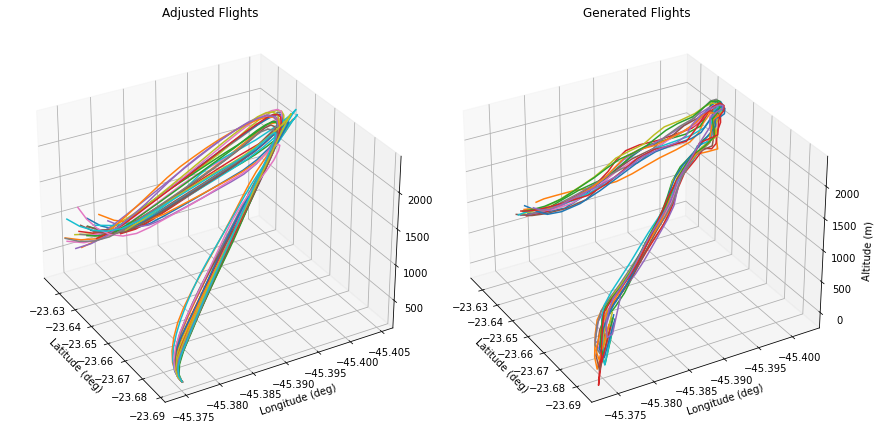

In [91]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to load flight data from directory
def load_flight_data(directory, pattern='SimuladorDeVoo_*.txt'):
    file_pattern = os.path.join(directory, pattern)
    files = glob.glob(file_pattern)
    flight_data = []
    for file in files:
        df = pd.read_csv(file, delimiter='\t')
        flight_data.append(df)
    return flight_data

# Plotting function
def plot_flights_3d(flight_data, title, ax, elev, azim):
    for flight in flight_data:
        ax.plot(flight['LAT(deg)'], flight['LON(deg)'], flight['ALT(m)'])
    ax.set_xlabel('Latitude (deg)')
    ax.set_ylabel('Longitude (deg)')
    ax.set_zlabel('Altitude (m)')
    ax.set_title(title)
    ax.view_init(elev=elev, azim=azim)

# Load adjusted flights
adjusted_flights_dir = './data/adjusted_flights/'
adjusted_flights = load_flight_data(adjusted_flights_dir)

# Load generated flights
generated_flights_dir = './data/generated_flights_15/'
generated_flights = load_flight_data(generated_flights_dir, pattern='GeneratedFlight_*.txt')

# Create 3D plot
fig = plt.figure(figsize=(12, 6))

# Adjust the view angles: elevation and azimuth
elevation_angle = 30  # Elevation angle in degrees
azimuth_angle = 150   # Azimuth angle in degrees

# Plot adjusted flights
ax1 = fig.add_subplot(121, projection='3d')
plot_flights_3d(adjusted_flights, 'Adjusted Flights', ax1, elevation_angle, azimuth_angle)

# Plot generated flights
ax2 = fig.add_subplot(122, projection='3d')
plot_flights_3d(generated_flights, 'Generated Flights', ax2, elevation_angle, azimuth_angle)

plt.tight_layout()
plt.show()


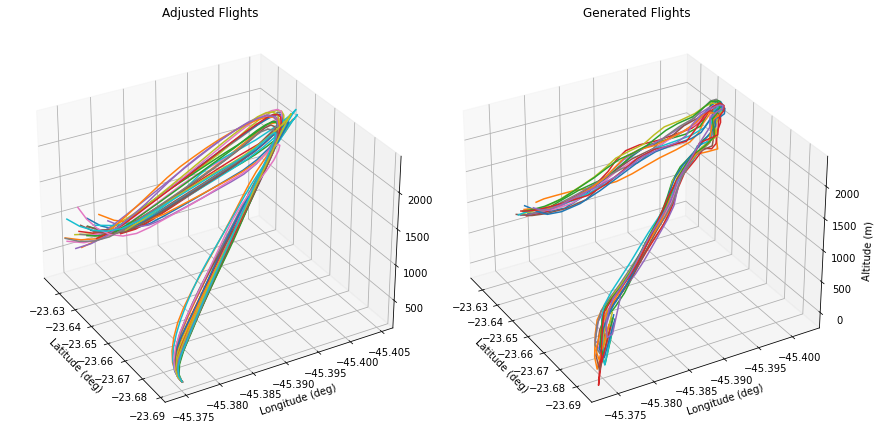

In [92]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to load flight data from directory
def load_flight_data(directory, pattern='SimuladorDeVoo_*.txt'):
    file_pattern = os.path.join(directory, pattern)
    files = glob.glob(file_pattern)
    flight_data = []
    for file in files:
        df = pd.read_csv(file, delimiter='\t')
        flight_data.append(df)
    return flight_data

# Plotting function
def plot_flights_3d(flight_data, title, ax, elev, azim):
    for flight in flight_data:
        ax.plot(flight['LAT(deg)'], flight['LON(deg)'], flight['ALT(m)'])
    ax.set_xlabel('Latitude (deg)')
    ax.set_ylabel('Longitude (deg)')
    ax.set_zlabel('Altitude (m)')
    ax.set_title(title)
    ax.view_init(elev=elev, azim=azim)

# Load adjusted flights
adjusted_flights_dir = './data/adjusted_flights/'
adjusted_flights = load_flight_data(adjusted_flights_dir)

# Load generated flights
generated_flights_dir = './data/generated_flights_15/'
generated_flights = load_flight_data(generated_flights_dir, pattern='GeneratedFlight_*.txt')

# Create 3D plot
fig = plt.figure(figsize=(12, 6))

# Adjust the view angles: elevation and azimuth
elevation_angle = 30  # Elevation angle in degrees
azimuth_angle = 150   # Azimuth angle in degrees

# Plot adjusted flights
ax1 = fig.add_subplot(121, projection='3d')
plot_flights_3d(adjusted_flights, 'Adjusted Flights', ax1, elevation_angle, azimuth_angle)

# Plot generated flights
ax2 = fig.add_subplot(122, projection='3d')
plot_flights_3d(generated_flights, 'Generated Flights', ax2, elevation_angle, azimuth_angle)

plt.tight_layout()
plt.show()


In [93]:
#Moving average
def apply_smoothing(data, window_size=10):
    # Applies smoothing with a moving average to each numeric column
    smoothed_data = data.copy()
    smoothed_data.iloc[:, :-3] = data.iloc[:, :-3].rolling(window=window_size, min_periods=1, center=True).mean()
    return smoothed_data

def process_files(input_folder, output_folder):
    # Checks if the output folder exists; if not, creates it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Iterates over all .txt files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".txt"):
            # Full file path
            file_path = os.path.join(input_folder, filename)
            
            # Reads the .txt file into a DataFrame
            df = pd.read_csv(file_path, sep='\t')
            
            # Applies the smoothing
            smoothed_df = apply_smoothing(df)
            
            # Full path for the output file
            output_file_path = os.path.join(output_folder, filename)
            
            # Saves the smoothed file in the output folder
            smoothed_df.to_csv(output_file_path, sep='\t', index=False)
            
            print(f"Smoothing applied and file saved: {output_file_path}")

# num_synthetic_flights_list = [15, 30, 100, 500, 1000, 3000]

for num_synthetic_flights in num_synthetic_flights_list:
    # Defines the input and output folders
    input_folder = f'./data/generated_flights_{num_synthetic_flights}'
    output_folder = f'./data/smoothed_flights_{num_synthetic_flights}'

    # Processes the files
    process_files(input_folder, output_folder)

Smoothing applied and file saved: ./data/smoothed_flights_7/GeneratedFlight_2.txt
Smoothing applied and file saved: ./data/smoothed_flights_7/GeneratedFlight_3.txt
Smoothing applied and file saved: ./data/smoothed_flights_7/GeneratedFlight_6.txt
Smoothing applied and file saved: ./data/smoothed_flights_7/GeneratedFlight_5.txt
Smoothing applied and file saved: ./data/smoothed_flights_7/GeneratedFlight_1.txt
Smoothing applied and file saved: ./data/smoothed_flights_7/GeneratedFlight_4.txt
Smoothing applied and file saved: ./data/smoothed_flights_7/GeneratedFlight_7.txt
Smoothing applied and file saved: ./data/smoothed_flights_15/GeneratedFlight_14.txt
Smoothing applied and file saved: ./data/smoothed_flights_15/GeneratedFlight_2.txt
Smoothing applied and file saved: ./data/smoothed_flights_15/GeneratedFlight_8.txt
Smoothing applied and file saved: ./data/smoothed_flights_15/GeneratedFlight_3.txt
Smoothing applied and file saved: ./data/smoothed_flights_15/GeneratedFlight_6.txt
Smoothing 

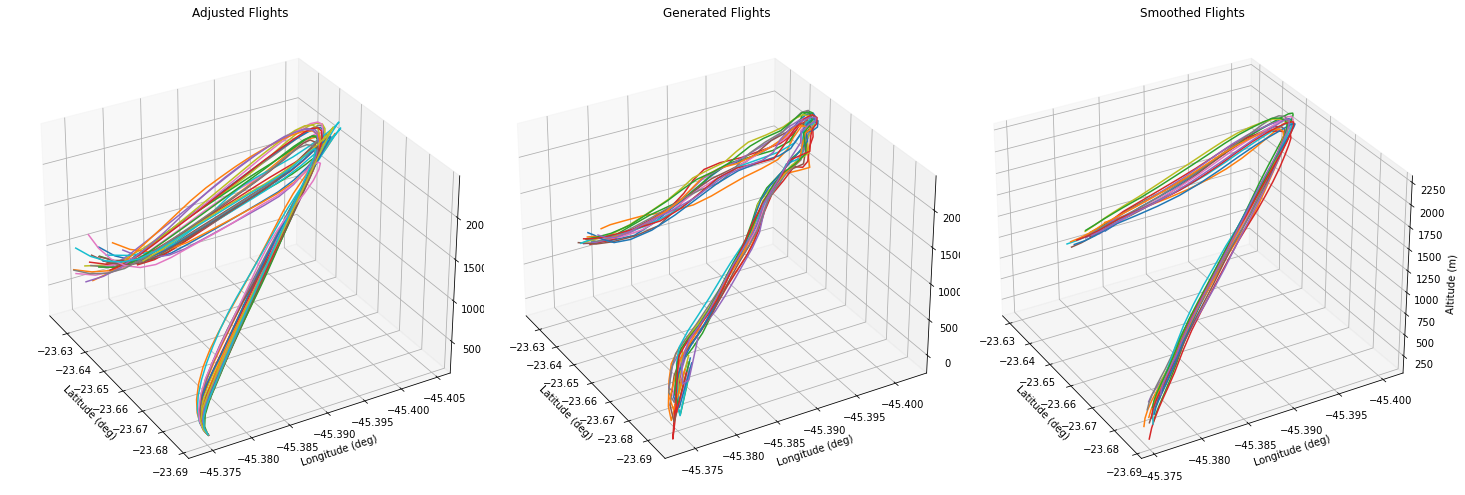

In [94]:
# Load adjusted flights
adjusted_flights_dir = './data/adjusted_flights/'
adjusted_flights = load_flight_data(adjusted_flights_dir)

# Load generated flights
generated_flights_dir = './data/generated_flights_15/'
generated_flights = load_flight_data(generated_flights_dir, pattern='GeneratedFlight_*.txt')

# Load generated flights
smoothed_flights_dir = './data/smoothed_flights_15/'
smoothed_flights = load_flight_data(smoothed_flights_dir, pattern='GeneratedFlight_*.txt')

# Create 3D plot
fig = plt.figure(figsize=(20, 20))

# Adjust the view angles: elevation and azimuth
elevation_angle = 30  # Elevation angle in degrees
azimuth_angle = 150   # Azimuth angle in degrees

# Plot adjusted flights
ax1 = fig.add_subplot(131, projection='3d')
plot_flights_3d(adjusted_flights, 'Adjusted Flights', ax1, elevation_angle, azimuth_angle)

# Plot generated flights
ax2 = fig.add_subplot(132, projection='3d')
plot_flights_3d(generated_flights, 'Generated Flights', ax2, elevation_angle, azimuth_angle)

# Plot smoothed flights
ax2 = fig.add_subplot(133, projection='3d')
plot_flights_3d(smoothed_flights, 'Smoothed Flights', ax2, elevation_angle, azimuth_angle)

plt.tight_layout()
plt.show()

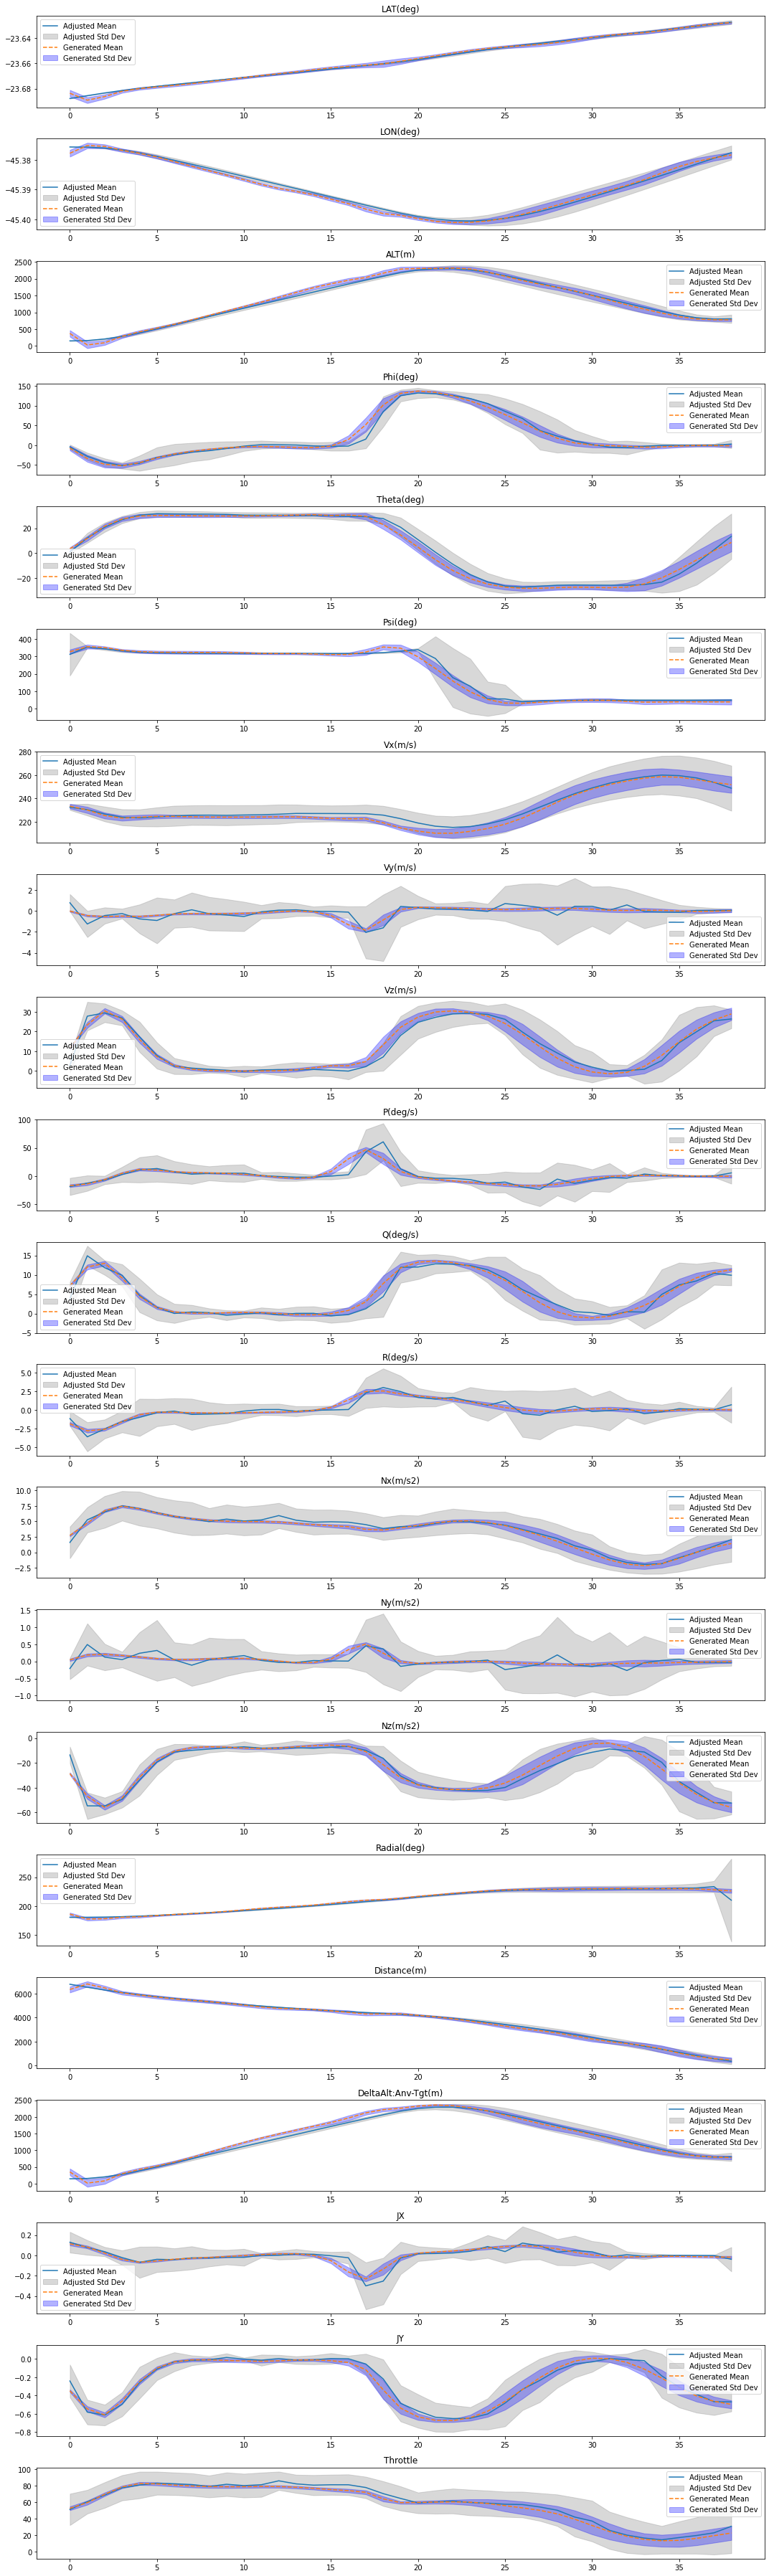

In [95]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to load and process flight data from a directory
def load_flight_data_from_directory(directory):
    file_pattern = os.path.join(directory, '*.txt')
    files = glob.glob(file_pattern)
    flights = []
    for file_path in files:
        df = pd.read_csv(file_path, delimiter='\t')
        # Drop the 'Time(milli)' column if it exists
        if 'Time(milli)' in df.columns:
            df = df.drop(columns=['Time(milli)'])
        flights.append(df.values)
    return np.array(flights)

# Load adjusted and generated flight data
adjusted_flights = load_flight_data_from_directory('./data/adjusted_flights/')
generated_flights = load_flight_data_from_directory('./data/generated_flights_15/')

# Function to calculate mean and standard deviation across all flight samples
def calculate_mean_and_std(flights):
    mean_flight = np.mean(flights, axis=0)
    std_flight = np.std(flights, axis=0)
    return mean_flight, std_flight

# Calculate mean and std for adjusted and generated flights
mean_adjusted, std_adjusted = calculate_mean_and_std(adjusted_flights)
mean_generated, std_generated = calculate_mean_and_std(generated_flights)

# Plot the comparison between adjusted and generated flight data
def plot_comparison(mean_adjusted, std_adjusted, mean_generated, std_generated):
    columns_to_plot = [
        'LAT(deg)', 'LON(deg)', 'ALT(m)', 'Phi(deg)', 'Theta(deg)', 'Psi(deg)',
        'Vx(m/s)', 'Vy(m/s)', 'Vz(m/s)', 'P(deg/s)', 'Q(deg/s)', 'R(deg/s)',
        'Nx(m/s2)', 'Ny(m/s2)', 'Nz(m/s2)', 'Radial(deg)', 'Distance(m)', 'DeltaAlt:Anv-Tgt(m)',
        'JX', 'JY', 'Throttle'
    ]
    
    fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(15, 50))
    for i, col in enumerate(columns_to_plot):
        axes[i].plot(mean_adjusted[:, i], label='Adjusted Mean')
        axes[i].fill_between(range(mean_adjusted.shape[0]), 
                             mean_adjusted[:, i] - std_adjusted[:, i], 
                             mean_adjusted[:, i] + std_adjusted[:, i], 
                             color='gray', alpha=0.3, label='Adjusted Std Dev')
        axes[i].plot(mean_generated[:, i], label='Generated Mean', linestyle='--')
        axes[i].fill_between(range(mean_generated.shape[0]), 
                             mean_generated[:, i] - std_generated[:, i], 
                             mean_generated[:, i] + std_generated[:, i], 
                             color='blue', alpha=0.3, label='Generated Std Dev')
        axes[i].set_title(f'{col}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the comparison
plot_comparison(mean_adjusted, std_adjusted, mean_generated, std_generated)
